In [18]:
import numpy as np
import math
import sys
import progressbar
import matplotlib.pyplot as plt
import pandas as pd

In [123]:
def to_categorical(x, n_col=None):
    """ One-hot encoding номинального признака """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot
def divide_on_feature(X, feature_i, threshold):
    """ Разделение набора данных по превышению признака feature_i порога"""
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])
    return X_1, X_2


def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def shuffle_data(X, y, seed=None):
    """ случайное перемешивание X и y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Разделение набора данных на обучающий и тестовый """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def to_nominal(x):
    """ Перевод из one-hot encoding в номинальные значения """
    return np.argmax(x, axis=1)

def calculate_entropy(y):
    """ энтропия """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ дисперсия X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def mean_squared_error(y_true, y_pred):
    """ средняя квадратичная ошибка (y_true, y_pred) """
    mse = (np.power(y_true - y_pred, 2)).mean()
    return mse

def accuracy_score(y_true, y_pred):
    """ Доля правильных ответов """
    accuracy = np.mean(y_true == y_pred, axis=0)
    return accuracy

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
    
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)
    
bar_widgets = [
    'Обучение: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [124]:
class DecisionNode():
    """Узел или лист дерева

    Параметры:
    -----------
    feature_i: int
        Номер признака, используемого для ветвления.
    threshold: float
        Пороговое значение, с которым мы будем сравнивать значения признака feature_i при определении прогноза.
    value: float
        Предсказанный класс для задачи классификации или предсказанное значение числового признака y для задачи регрессии.
    true_branch: DecisionNode
        Следующий узел в случае превышения порога.
    false_branch: DecisionNode
        Следующий узел в случае недостижения порога.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i         
        self.threshold = threshold          
        self.value = value                 
        self.true_branch = true_branch      
        self.false_branch = false_branch    

In [125]:
class DecisionTree(object):
    """Родительский класс для RegressionTree и ClassificationTree.

    Параметры:
    -----------
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потреь, используемая в градиентном бустинге для вычисления информативности.
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Корневой узел
       
        self.min_samples_split = min_samples_split
        
        self.min_impurity = min_impurity
        
        self.max_depth = max_depth
        
        self._impurity_calculation = None
       
        self._leaf_value_calculation = None
       
        self.one_dim = None
        
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Построение дерева """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Рекурсивный метод, который строит дерево решений и разбивает X и соответствующий y 
        по признаку, который (на основе информативности) наилучшим образом разделяет данные"""

        largest_impurity = 0
        best_criteria = None    # номер факторного признака и порог
        best_sets = None        # Подмножества данных

        # 
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # 
        #X = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)  # Добавляем нулевой столбец к X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Вычисляем информативность для каждого факторного признака
            for feature_i in range(n_features):
                # ВСЕ значения признака feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                
                # Цикл по всем уникальным значениям feature_i с вычислением информативности
                for threshold in unique_values:
                    # Разделение X и y по критерию X[feature_i] >= threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Значения y-в двух подмножествах
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Вычисление информативности
                        impurity = self._impurity_calculation(y, y1, y2)

                        # Если порог привел к повышению информационного выигрыша,
                        # сохраним порогт и номер признака
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X левого поддерева
                                "lefty": Xy1[:, n_features:],   # y левого поддерева
                                "rightX": Xy2[:, :n_features],  # X правого поддерева
                                "righty": Xy2[:, n_features:]   # y правого поддерева
                                }

        if largest_impurity > self.min_impurity:
            # Строим поддеревья
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # Определение значения в листе
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Рекурсивный поиск вниз по дереву с построением прогноза по значению итогового листа"""

        if tree is None:
            tree = self.root

        # Если мы находимся в листе, т.е. есть значение value, возвращаем его как прогноз
        if tree.value is not None:
            return tree.value

        # Выбор факторного признака
        feature_value = x[tree.feature_i]

        # Выбор левого или правого поддерева в зависимости от превышения порога
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Прогноз на поддереве
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Поэлементная классификация набора данных с возвращением множества прогнозов y"""
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Рекурсивный вывод дерева """
        if not tree:
            tree = self.root

        # Если это лист, выводим значение
        if tree.value is not None:
            print (tree.value)
        # иначе идем вглубь
        else:
            # номер признака и порог
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Сценарий при достижении порога
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Сценарий при недостижении порога
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

In [126]:
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Вычисление уменьшения дисперсии
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Вычисление информационного выигрыша
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Вычисление размера мажоритарного класса
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [6]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)


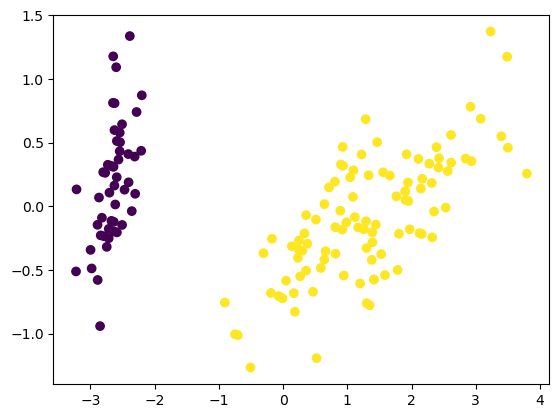

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [9]:
dt = ClassificationTree(min_samples_split=10, min_impurity=1e-7, max_depth=5)
dt.fit(X_train, y_train)

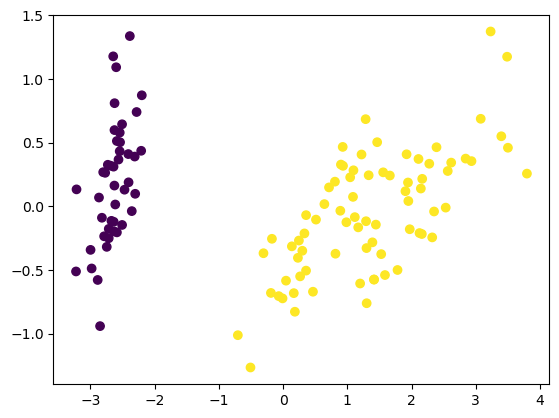

In [10]:
y_pred = dt.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

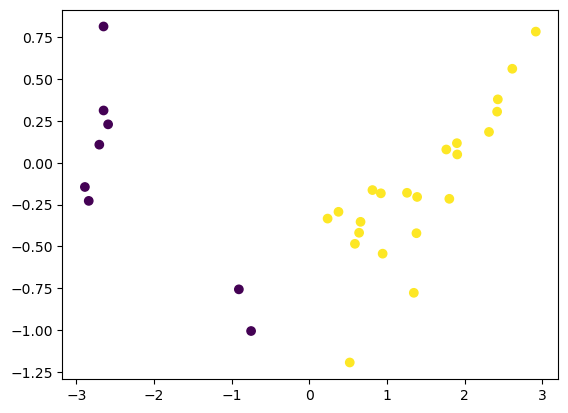

In [11]:
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [12]:
dt.print_tree()

0:-0.7045317592446648? 
 T->1.0
 F->0.0


In [127]:
class GradientBoosting(object):
    """Родительский класс для GradientBoostingClassifier и GradientBoostinRegressor. 
    Использует набор деревьев для обучения предсказанию градиента функции потерь. 

    Параметры:
    -----------
    n_estimators: int
        Число деревьев.
    learning_rate: float
        Скорость обучения - длина шага в направлении антиградиента
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потерь, используемая в градиентном бустинге для вычисления информативности.
    regression: boolean
        Регрессия или классификация.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)
        
        # Средняя квадратичная ошибка для регрессии, кросс-энтропия для классификации
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        # Инициализация
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in self.bar(range(self.n_estimators)):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Обновление прогноза y
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        # Вычисление прогнозов
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            # переход к распределению вероятностей
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Прогноз - значение с максимальной вероятностью
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

Обучение: 100% [------------------------------------------------] Time: 0:00:25


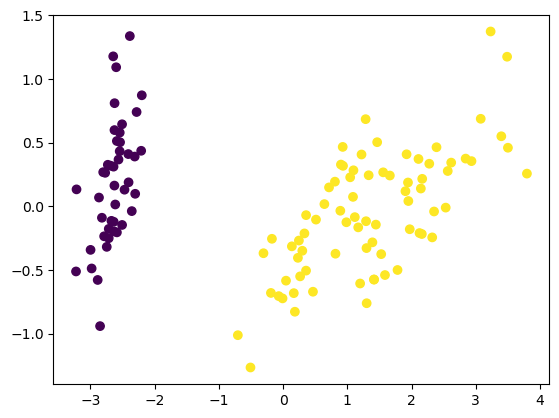

In [14]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=.05, min_samples_split=2, min_info_gain=1e-7, max_depth=4, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

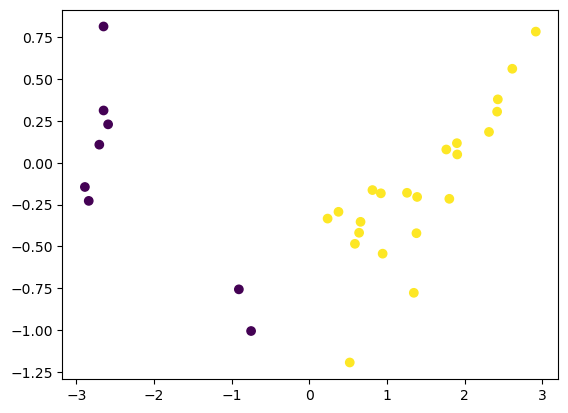

In [15]:
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [16]:
for t in gbc.trees:
    t.print_tree()

0:-0.7045317592446648? 
 T->[ 1.57894737 -1.57894737]
 F->[-2.72727273  2.72727273]
0:-0.7045317592446648? 
 T->[ 1.40394089 -1.40394089]
 F->[-1.98795181  1.98795181]
0:-0.7045317592446648? 
 T->[ 1.27799162 -1.27799162]
 F->[-1.6599497  1.6599497]
0:-0.7045317592446648? 
 T->[ 1.18150613 -1.18150613]
 F->[-1.45894802  1.45894802]
0:-0.7045317592446648? 
 T->[ 1.10442 -1.10442]
 F->[-1.31861273  1.31861273]
0:-0.7045317592446648? 
 T->[ 1.04093624 -1.04093624]
 F->[-1.21314552  1.21314552]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.12999369  1.12999369]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.06217959  1.06217959]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.0054603  1.0054603]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446648? 
 T->[ 1. -1.]
 F->

Реализовать классификацию градиентным бустингом для набора данных German Credit Cards UCI.csv
Реализовать регрессию градиентным бустингом для набора данных Video Games
Сравнить метрики качества и скорость обучения с ранее построенными моделями.

# Классификация

In [128]:
df = pd.read_csv('German Credit Cards UCI.csv')
df = df.drop('Customer ID', axis = 1)
df = df.drop_duplicates().reset_index(drop = True)
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12,current loans paid,furniture/equipment,1736,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,...,real estate,31,none,own,1,unskilled-resident,1,none,yes,fully paid
996,< 0 DM,30,current loans paid,car (used),3857,< 100 DM,1 - 4 years,4,male-divorced/separated,none,...,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes,fully paid
997,none,12,current loans paid,radio/television,804,< 100 DM,>= 7 years,4,male-single,none,...,car or other,38,none,own,1,skilled,1,none,yes,fully paid
998,< 0 DM,45,current loans paid,radio/television,1845,< 100 DM,1 - 4 years,4,male-single,none,...,unknown-none,23,none,for free,1,skilled,1,yes,yes,charged off


In [129]:
# сразу отделим целевую переменную

labelencoder = LabelEncoder()
df['Loan Status'] = labelencoder.fit_transform(df['Loan Status'].values)
y = np.array(df['Loan Status'])
df = df.drop('Loan Status', axis = 1)
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,Present Residence Time (Years),Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status
0,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,3,real estate,49,none,own,1,unskilled-resident,2,none,yes
3,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,4,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes
4,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,4,unknown-none,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12,current loans paid,furniture/equipment,1736,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,4,real estate,31,none,own,1,unskilled-resident,1,none,yes
996,< 0 DM,30,current loans paid,car (used),3857,< 100 DM,1 - 4 years,4,male-divorced/separated,none,4,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes
997,none,12,current loans paid,radio/television,804,< 100 DM,>= 7 years,4,male-single,none,4,car or other,38,none,own,1,skilled,1,none,yes
998,< 0 DM,45,current loans paid,radio/television,1845,< 100 DM,1 - 4 years,4,male-single,none,4,unknown-none,23,none,for free,1,skilled,1,yes,yes


In [130]:
# работа с числовыми признаками
df_num = df.select_dtypes(exclude = 'object')

def replace_outliers_with_median_for_column(df, column_name, threshold=1.5):
    data = df[column_name]
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    lower_bound = q25 - (threshold * iqr)
    upper_bound = q75 + (threshold * iqr)
    median = np.median(data)
    
    data_without_outliers = np.where((data < lower_bound) | (data > upper_bound), median, data)
    
    df[column_name] = data_without_outliers
    
    return df

replace_outliers_with_median_for_column(df, 'Loan Amount')
replace_outliers_with_median_for_column(df, 'Loan Duration (Months)')
df

,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,Other Debtors / Guarantors,Present Residence Time (Years),Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status
0,< 0 DM,6.0,critical account - other non-bank loans,radio/television,1169.0,unknown/none,>= 7 years,4,male-single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0 - 200 DM,18.0,current loans paid,radio/television,5951.0,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,none,12.0,critical account - other non-bank loans,education,2096.0,< 100 DM,4 - 7 years,2,male-single,none,3,real estate,49,none,own,1,unskilled-resident,2,none,yes
3,< 0 DM,42.0,current loans paid,furniture/equipment,7882.0,< 100 DM,4 - 7 years,2,male-single,guarantor,4,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes
4,< 0 DM,24.0,past payment delays,car (new),4870.0,< 100 DM,1 - 4 years,3,male-single,none,4,unknown-none,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,none,12.0,current loans paid,furniture/equipment,1736.0,< 100 DM,4 - 7 years,3,female-divorced/separated/married,none,4,real estate,31,none,own,1,unskilled-resident,1,none,yes
996,< 0 DM,30.0,current loans paid,car (used),3857.0,< 100 DM,1 - 4 years,4,male-divorced/separated,none,4,building society savings/life insurance,40,none,own,1,highly skilled,1,yes,yes
997,none,12.0,current loans paid,radio/television,804.0,< 100 DM,>= 7 years,4,male-single,none,4,car or other,38,none,own,1,skilled,1,none,yes
998,< 0 DM,18.0,current loans paid,radio/television,1845.0,< 100 DM,1 - 4 years,4,male-single,none,4,unknown-none,23,none,for free,1,skilled,1,yes,yes


In [131]:
# работа с категориальными признаками
from sklearn.preprocessing import LabelEncoder
df_obj = df.select_dtypes(include = 'object')

labelencoder = LabelEncoder()
df['Credit History'] = labelencoder.fit_transform(df['Credit History'].values)
df['Job Category'] = labelencoder.fit_transform(df['Job Category'].values)
df_obj = df_obj.drop(['Credit History','Job Category'], axis = 1)

df = pd.get_dummies(df, prefix= df_obj.columns, dtype="float64")
df

,Loan Duration (Months),Credit History,Loan Amount,Installment Rate in Percentage of Disposable Income,Present Residence Time (Years),Age (Years),Number of Existing Credits at This Bank,Job Category,Number of Dependents,Checking Account Status_0 - 200 DM,...,Other Credits_bank,Other Credits_none,Other Credits_stores,Home Ownership_for free,Home Ownership_own,Home Ownership_rent,Telephone_none,Telephone_yes,Foreign Worker Status_no,Foreign Worker Status_yes
0,6.0,1,1169.0,4,4,67,2,1,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,18.0,2,5951.0,2,2,22,1,1,1,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,12.0,1,2096.0,2,3,49,1,3,2,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,42.0,2,7882.0,2,4,45,1,1,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,24.0,4,4870.0,3,4,53,2,1,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,2,1736.0,3,4,31,1,3,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
996,30.0,2,3857.0,4,4,40,1,0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
997,12.0,2,804.0,4,4,38,1,1,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
998,18.0,2,1845.0,4,4,23,1,1,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [132]:
from sklearn.preprocessing import StandardScaler
def standardize_dataframe(df):
    scaler = StandardScaler()
    df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_standardized
df = standardize_dataframe(df)
df

,Loan Duration (Months),Credit History,Loan Amount,Installment Rate in Percentage of Disposable Income,Present Residence Time (Years),Age (Years),Number of Existing Credits at This Bank,Job Category,Number of Dependents,Checking Account Status_0 - 200 DM,...,Other Credits_bank,Other Credits_none,Other Credits_stores,Home Ownership_for free,Home Ownership_own,Home Ownership_rent,Telephone_none,Telephone_yes,Foreign Worker Status_no,Foreign Worker Status_yes
0,-1.437321,-0.894641,-0.858779,0.918477,1.046987,2.766456,1.027079,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,-1.214598,1.214598,-0.196014,0.196014
1,-0.071371,0.189772,1.913058,-0.870183,-0.765977,-1.191404,-0.704926,-0.289639,-0.428290,1.648476,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
2,-0.754346,-0.894641,-0.321453,-0.870183,0.140505,1.183312,-0.704926,1.824516,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
3,2.660529,0.189772,3.032342,-0.870183,1.046987,0.831502,-0.704926,-0.289639,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,0.823318,-0.823318,-0.196014,0.196014
4,0.611604,2.358599,1.286467,0.024147,1.046987,1.535122,1.027079,-0.289639,2.334869,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,0.823318,-0.823318,-0.196014,0.196014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.754346,0.189772,-0.530123,0.024147,1.046987,-0.399832,-0.704926,1.824516,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
996,1.294579,0.189772,0.699292,0.918477,1.046987,0.391740,-0.704926,-1.346717,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,-1.214598,1.214598,-0.196014,0.196014
997,-0.754346,0.189772,-1.070348,0.918477,1.046987,0.215835,-0.704926,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,-0.347960,0.634448,-0.466933,0.823318,-0.823318,-0.196014,0.196014
998,-0.071371,0.189772,-0.466943,0.918477,1.046987,-1.103451,-0.704926,-0.289639,-0.428290,-0.606621,...,-0.401796,0.478018,-0.222076,2.873893,-1.576173,-0.466933,-1.214598,1.214598,-0.196014,0.196014


In [44]:
X = np.array(df)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 54), (200, 54), (800,), (200,))

In [45]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=.05, min_samples_split=2, min_info_gain=1e-7, max_depth=4, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:12:47


In [46]:
y_pred

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [47]:
accuracy_score(y_train, y_pred)

0.89125

In [48]:
y_test_pr = gbc.predict(X_test)
y_test_pr

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1], dtype=int64)

In [49]:
accuracy_score(y_test, y_test_pr)

0.685

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pr)
print(cm)

[[44 19]
 [44 93]]


In [53]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pr)
f1

0.7469879518072289

In [55]:
for t in gbc.trees:
    t.print_tree()

12:1.2401899314177032? 
 T->45:0.4780180211050924? 
  T->5:-0.3118794015104515? 
    T->21:6.667424199385056? 
        T->0:0.611604178002297? 
                T->[ 1.42095915 -1.42095915]
                F->[-3.37552743  3.37552743]
        F->2:1.1247480122193159? 
                T->[ 0.82139833 -0.82139833]
                F->[ 1.42095915 -1.42095915]
    F->0:1.9775543242944176? 
        T->1:2.3585985070665125? 
                T->[-3.37552743  3.37552743]
                F->[ 0.2218375 -0.2218375]
        F->17:4.358898943540674? 
                T->[-3.37552743  3.37552743]
                F->[ 0.93040938 -0.93040938]
  F->5:-0.7516416709837335? 
    T->32:3.8896056687104568? 
        T->5:-0.22392694761579512? 
                T->[-3.37552743  3.37552743]
                F->[ 1.42095915 -1.42095915]
        F->5:0.5676451374361124? 
                T->[ 1.42095915 -1.42095915]
                F->[-0.12629459  0.12629459]
    F->[-3.37552743  3.37552743]
 F->0:-0.75434596828982

                T->[-1.  1.]
                F->[ 1. -1.]
        F->29:2.178790131421934? 
                T->[ 1. -1.]
                F->[ 0.01692999 -0.01692999]
    F->[-1.  1.]
 F->0:-0.7543459682898234? 
  T->5:2.502599123118553? 
    T->[ 1. -1.]
    F->26:4.453463071962462? 
        T->45:0.4780180211050924? 
                T->[ 1. -1.]
                F->[-0.20603684  0.20603684]
        F->2:-1.1833774121242644? 
                T->[-8.66723522e-05  8.66723522e-05]
                F->[ 1. -1.]
  F->42:1.5956501154012874? 
    T->7:-0.2896392973702557? 
        T->5:-0.9275465787730462? 
                T->[ 1. -1.]
                F->[ 0.00093694 -0.00093694]
        F->[-1.  1.]
    F->0:-0.9820043260051768? 
        T->[ 1. -1.]
        F->1:-0.8946408130252288? 
                T->[ 0.12854289 -0.12854289]
                F->[-1.  1.]
12:1.2401899314177032? 
 T->45:0.4780180211050924? 
  T->5:-0.3118794015104515? 
    T->2:1.1247480122193159? 
        T->5:1.623074584171

                F->[-0.1826915  0.1826915]
        F->2:-1.1833774121242644? 
                T->[-9.95127815e-12  9.95117503e-12]
                F->[ 1. -1.]
  F->42:1.5956501154012874? 
    T->7:-0.2896392973702557? 
        T->5:-0.9275465787730462? 
                T->[ 1. -1.]
                F->[ 5.45691165e-07 -5.45691164e-07]
        F->[-1.  1.]
    F->0:-0.9820043260051768? 
        T->[ 1. -1.]
        F->1:-0.8946408130252288? 
                T->[ 0.12827236 -0.12827236]
                F->[-1.  1.]
12:1.2401899314177032? 
 T->45:0.4780180211050924? 
  T->5:-0.3118794015104515? 
    T->2:1.1247480122193159? 
        T->5:1.6230745841719891? 
                T->[-0.78064663  0.78064663]
                F->[ 0.88160611 -0.88160611]
        F->21:6.667424199385056? 
                T->[-1.  1.]
                F->[ 1. -1.]
    F->1:0.1897722936720183? 
        T->3:0.9184771676276685? 
                T->[ 0.06299773 -0.06299773]
                F->[ 0.62575194 -0.62575194]


# Регрессия

In [133]:
df = pd.read_csv('Video Games.csv')
df

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...,...
4253,3996,PSP,2010,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4254,5720,Wii,2007,Shooter,Nintendo,3.06,1.18,0.46,1.29
4255,4579,3DS,2015,Action,FuRyu,0.00,0.00,0.00,1.06
4256,4072,GB,1996,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [134]:
df = df[df.na_sales <=10]
df = df[df.eu_sales < 7]
df = df[df.jp_sales < 10]
df = df.reset_index(drop = True)
df

,id,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,2830,PSV,2012,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,3865,SNES,1996,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,4617,PSP,2009,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,3675,DS,2007,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,1612,PSV,2016,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...,...
4240,3996,PSP,2010,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4241,5720,Wii,2007,Shooter,Nintendo,3.06,1.18,0.46,1.29
4242,4579,3DS,2015,Action,FuRyu,0.00,0.00,0.00,1.06
4243,4072,GB,1996,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [135]:
df = df.drop('id', axis = 1)

In [136]:
year = (df['year'] - df['year'].min ())/(df['year'].max() - df['year'].min())
df['year'] = year.values
df

,platform,year,genre,publisher,na_sales,eu_sales,other_sales,jp_sales
0,PSV,0.852941,Racing,Electronic Arts,0.38,0.52,0.25,1.01
1,SNES,0.382353,Role-Playing,ASCII Entertainment,0.00,0.00,0.00,1.31
2,PSP,0.764706,Sports,Takara Tomy,0.09,0.00,0.01,1.04
3,DS,0.705882,Fighting,Takara Tomy,0.00,0.00,0.00,1.08
4,PSV,0.970588,Action,Namco Bandai Games,0.00,0.00,0.00,1.12
...,...,...,...,...,...,...,...,...
4240,PSP,0.794118,Adventure,Tecmo Koei,0.00,0.00,0.00,1.09
4241,Wii,0.705882,Shooter,Nintendo,3.06,1.18,0.46,1.29
4242,3DS,0.941176,Action,FuRyu,0.00,0.00,0.00,1.06
4243,GB,0.382353,Role-Playing,ChunSoft,0.00,0.00,0.00,1.27


In [137]:
df = pd.get_dummies(df, prefix=['platform', 'genre', 'publisher'], dtype="float64")
df

,year,na_sales,eu_sales,other_sales,jp_sales,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,...,publisher_Yacht Club Games,publisher_Yamasa Entertainment,publisher_Yeti,publisher_Yuke's,publisher_Yumedia,publisher_Zenrin,publisher_Zoo Digital Publishing,publisher_Zushi Games,publisher_dramatic create,publisher_imageepoch Inc.
0,0.852941,0.38,0.52,0.25,1.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.382353,0.00,0.00,0.00,1.31,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.764706,0.09,0.00,0.01,1.04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705882,0.00,0.00,0.00,1.08,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.970588,0.00,0.00,0.00,1.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,0.794118,0.00,0.00,0.00,1.09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.705882,3.06,1.18,0.46,1.29,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.941176,0.00,0.00,0.00,1.06,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4243,0.382353,0.00,0.00,0.00,1.27,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
Y = df['jp_sales']
X = df.drop(['jp_sales'], axis = 1)
X

,year,na_sales,eu_sales,other_sales,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,platform_GBA,...,publisher_Yacht Club Games,publisher_Yamasa Entertainment,publisher_Yeti,publisher_Yuke's,publisher_Yumedia,publisher_Zenrin,publisher_Zoo Digital Publishing,publisher_Zushi Games,publisher_dramatic create,publisher_imageepoch Inc.
0,0.852941,0.38,0.52,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.382353,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.764706,0.09,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705882,0.00,0.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.970588,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,0.794118,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.705882,3.06,1.18,0.46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.941176,0.00,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4243,0.382353,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3396, 315), (849, 315), (3396,), (849,))

In [140]:
X_train = X_train.iloc[0:20]
X_train

,year,na_sales,eu_sales,other_sales,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,platform_GBA,...,publisher_Yacht Club Games,publisher_Yamasa Entertainment,publisher_Yeti,publisher_Yuke's,publisher_Yumedia,publisher_Zenrin,publisher_Zoo Digital Publishing,publisher_Zushi Games,publisher_dramatic create,publisher_imageepoch Inc.
3184,0.823529,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3159,0.176471,0.96,0.38,0.05,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177,0.352941,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3151,0.911765,0.33,0.48,0.18,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2726,0.970588,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3475,0.794118,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.882353,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450,0.647059,1.81,0.05,0.15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,0.500000,0.16,0.13,0.04,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4053,0.411765,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
y_train = y_train.iloc[0:20]
y_train

3184    1.03
3159    1.55
2177    1.05
3151    1.02
2726    1.02
3475    1.03
194     1.02
450     1.01
1918    1.06
4053    1.16
4131    1.03
29      2.09
3598    1.04
2288    1.29
2183    4.12
3358    1.01
3328    1.12
1186    1.02
1270    1.01
3678    1.08
Name: jp_sales, dtype: float64

In [147]:
X_train = np.array(X_train)
y_train = np.array(y_train.values)

In [143]:
X_train.shape

(20, 315)

In [163]:
gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=.05, min_samples_split=2, min_var_red=1e-7, max_depth=4, debug=False)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_train)

Обучение: 100% [------------------------------------------------] Time: 0:43:35


In [164]:
y_pred

array([-0.12467696,  0.46241772,  0.00481715, ...,  0.59521321,
       -0.11036515, -0.11023339])

In [155]:
y_train

array([1.03, 1.55, 1.05, ..., 1.71, 1.01, 1.04])

In [165]:
mean_squared_error(y_train, y_pred)

1.5026286682793295

In [166]:
y_test_pr = gbr.predict(np.array(X_test))
y_test_pr

array([ 2.86584324e-01, -6.08859501e-02,  1.48230674e-01, -6.17089180e-02,
       -1.24676958e-01, -1.24676958e-01, -8.76960300e-02, -1.10365153e-01,
       -1.67548357e-02, -8.64279554e-02, -3.06913074e-02, -1.10365153e-01,
       -1.21481631e-01, -1.07912679e-01, -1.24676958e-01,  1.85487049e-01,
       -1.24676958e-01, -1.24676958e-01,  1.22419506e-02, -1.13948330e-01,
       -1.10365153e-01, -1.22224484e-01, -1.24676958e-01,  5.72934033e-02,
        8.30536559e-03, -3.06913074e-02, -1.24676958e-01, -1.16749034e-01,
       -1.16749034e-01,  2.32528941e-02, -1.14680304e-01, -1.13948330e-01,
        4.03437553e-01,  2.76424873e-01, -1.02353099e-01, -9.08913569e-02,
       -1.02353099e-01, -4.83113656e-04,  5.06384931e-01,  1.22419506e-02,
       -1.21481631e-01, -1.24676958e-01, -1.19069749e-01, -1.10365153e-01,
       -7.81537203e-02, -1.13948330e-01, -9.08913569e-02, -1.22224484e-01,
       -8.59844764e-02, -1.20213557e-01,  1.18892069e-01, -9.08913569e-02,
       -1.24676958e-01, -

In [167]:
mean_squared_error(y_test, y_test_pr)

1.4853356151820543